<a href="https://colab.research.google.com/github/mimikuo365/Bike-Rider-Facilitating-System/blob/master/%5B20220309%5D%20%5B5%20Cities%5D%20%5BWith%20Tile%20Swapping%5D%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Functions

In [1]:
import pandas as pd
from skimage import io
import tifffile
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def reverse_element(list_of_pairs):
  ''' Revserse the lists inside a list
  
  '''
  reversed_list = []
  for pair in list_of_pairs:
    first = pair[0]
    second = pair[1]
    reversed_list.append([second, first])
  return reversed_list

In [3]:
def calculate_threshold(ratio_ls, origin_threshold_ls):
  updated_threshold_ls = []
  for ratio, orign_threshold in zip(ratio_ls, origin_threshold_ls):
    updated_threshold = ratio * orign_threshold
    updated_threshold_ls.append(updated_threshold)
  return updated_threshold_ls

In [4]:
def add_annotation(tiles_in_band, is_swapped, tile_height, tile_width, ax, xy, cur_value, threshold, avg_value):
  ''' Add rectangles and texts to a image
  
  '''
  color = 'y'
  if is_swapped:
    color = 'r'
    draw_rect(ax, xy, tile_height, tile_width)
  add_text(tiles_in_band, tile_height, tile_width, ax, xy, color, cur_value, avg_value, threshold)

In [5]:
def add_text(tiles_in_band, tile_height, tile_width, ax, xy, color, cur_value, avg_value, threshold):
  ''' Add text to the corresponding tile
  '''
  rx, ry = xy[0], xy[1]
  cx = rx + tile_width / 2.0
  cy = ry + tile_height / 2.0

  num = cur_value - avg_value
  str_int_cur_value = str(int(cur_value)) 
  str_int_avg_value = str(int(avg_value)) 
  str_int_threshold = str(int(threshold))

  if num != 0:
    txt = str_int_cur_value + '-' + str_int_avg_value
    txt += '\n(' + str_int_threshold + ')'
  else:
    txt = str_int_avg_value
  fontsize = get_fontsize(tiles_in_band)
  ax.annotate(txt, (cx, cy), fontsize=fontsize, color=color, ha='center', va='center')

In [6]:
def get_fontsize(tiles_in_band):
  if tiles_in_band <= 16: 
    return 7
  elif tiles_in_band <= 64:
    return 5
  elif tiles_in_band <= 256:
    return 2

In [7]:
# Circle the rectangle of the corresponding tile
def draw_rect(ax, xy, tile_height, tile_width):
  rect = patches.Rectangle(xy, tile_width, tile_height, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

In [8]:
# Collect the needed index based on the wanted bands
def get_wanted_image_band(selected_band, img):
  selected_img = np.array(img[:,:,selected_band])
  selected_img = np.reshape(selected_img, (selected_img.shape[0], selected_img.shape[1], 1))
  return selected_img

In [9]:
# Reshape the selected bands based on the number of channels
def select_mask_region(tiles_in_band, city, tile_height, tile_width, img, epiweek, 
                       all_index, swapped_index, cur_tile_ls, threshold_ls, avg_tile_ls):
  row_col_pairs = split_img_to_tiles(0, img, selected_band, tile_height, tile_width)
  xy_pairs = reverse_element(row_col_pairs)

  # Create figure and axes
  fig, ax = plt.subplots(constrained_layout=True)
  img = img.reshape(img.shape[0], img.shape[1]).astype(float)
  ax.axis('off')
  plt.imshow(img, cmap='gray')

  for i in all_index:
    xy = xy_pairs[i]
    cur_value = cur_tile_ls[i]
    avg_value = avg_tile_ls[i]
    threshold = threshold_ls[i]
    if i in swapped_index:
      add_annotation(tiles_in_band, True, tile_height, tile_width, ax, xy, cur_value, threshold, avg_value)
    else:
      add_annotation(tiles_in_band, False, tile_height, tile_width, ax, xy, cur_value, threshold, avg_value)

  if epiweek != None:
    plt.title(str(epiweek))
    folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset/analysis/5_cities/' + city + '/' + str(tiles_in_band) + '_tiles/'
    check_folder(folder)
    plt.savefig(folder + str(epiweek) + '.jpg', dpi=300)

  # plt.show()
  plt.close()

In [10]:
# Select the index
def obtain_index_range(selected_band):
  selected_index = [*range(tiles_in_band * selected_band, tiles_in_band * selected_band + tiles_in_band)]
  selected_index = np.array(selected_index).flatten()
  # print('Selected tile index to analyze:', selected_index)
  return selected_index

In [11]:
def check_folder(path):
  # Check whether the specified path exists or not
  isExist = os.path.exists(path)

  # Create a new directory because it does not exist 
  if not isExist:
    os.makedirs(path)

In [12]:
def load_csv_to_dict(filename):
  # Create a dictionary to store wanted columns from CSV
  dic = {
      'epiweek': [],
      'image': [],
      'cases': []
      }
  
  df = pd.read_csv(filename)

  # Read images from folder
  for index, row in df.iterrows():
    img_loc = row['img_loc']
    img = io.imread(img_loc)

    dic['image'].append(img)
    dic['epiweek'].append(row['epiweek'])
    dic['cases'].append(row['Cases'])

  dic['epiweek'] = np.array(dic['epiweek'])
  dic['image'] = np.array(dic['image'])
  dic['cases'] = np.array(dic['cases'])

  return dic

In [13]:
def get_pixels_per_tile(img, height_split, width_split):
  # Get height, width, band from the image's shape
  height, width, band = img.shape
  
  # Count height and width pixel for a tile 
  tile_height = int(height / height_split)
  tile_width = int(width / width_split)
  return tile_height, tile_width

In [14]:
def run_tile_transformation_on_all(img_ls, selected_band, tile_height, tile_width):
  # Perform image to tile transformation for every image 
  all_img_tiles = []

  for img in img_ls:
    img_tiles = split_img_to_tiles(1, img, selected_band, tile_height, tile_width)
    all_img_tiles.append(img_tiles)
  return all_img_tiles

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import  mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [(f'var({j+1})') for j in range(n_vars)]
    else:
      names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]

  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)

  return agg

def removeLastWeek(data, n_features):
  return data[:,:-n_features]

In [16]:
def make_prediction(option, title, max_y, min_y, y_train_pred, y_train, y_test_pred, y_test):
  plt.ylim(min_y, max_y)
  if option == "combine":
    y_pred = np.concatenate((y_train_pred, y_test_pred), axis=None)
    y_true = np.concatenate((y_train, y_test), axis=None)
    plt.plot(y_pred, label = 'predicted', color='c')
    plt.plot(y_true, label = 'actual', color='b')
    plt.plot([len(y_train), len(y_train)], [min_y, max_y], color="r")

  else:  
    train_ls = [*range(0, len(y_train), 1)]
    test_ls = [*range(len(y_train), len(y_train) + len(y_test), 1)]

    plt.plot(train_ls, y_train_pred, label = 'train predicted', color=(1, 0, 0, 0.5))
    plt.plot(train_ls, y_train, label = 'train actual', color=(0, 1, 0, 0.5))
    plt.plot(test_ls, y_test_pred, label = 'test predicted', color=(1, 0, 0, 1))
    plt.plot(test_ls, y_test, label = 'test actual', color=(0, 1, 0, 1))

  plt.legend(loc="upper left")
  plt.title(title)
  plt.show()

In [17]:
# Split images into tiles by indicating the window size for rows and columns
def split_img_to_tiles(option, cur_img, selected_band, windowsize_r, windowsize_c, avg_img=None):
  return_ls = []
  height = cur_img.shape[0] 
  width = cur_img.shape[1]

  for r in range(0, height - windowsize_r + 1, windowsize_r):
    for c in range(0, width - windowsize_c + 1, windowsize_c):

      if option == 0:
        return_ls.append([r, c])
      
      elif option == 1:
        window = cur_img[r:r+windowsize_r, c:c+windowsize_c, selected_band:selected_band+1]
        # window_avg = max(window.flatten())
        window_avg = round(np.average(window), 2)
        return_ls.append(window_avg)

  return np.array(return_ls)

In [18]:
def check_every_tile_with_std(tiles_in_band, img, city, tile_height, tile_width, threshold_list, cur_tile_ls, avg_tile_ls):
  updated_img_tiles = cur_tile_ls.copy()
  removed_tiles_counter = 0
  swapped_index = []
  num_of_tiles = len(avg_tile_ls)

  for i in range(num_of_tiles):
    threshold = threshold_list[i]
    
    cur_tile_value = cur_tile_ls[i]
    avg_tile_value = avg_tile_ls[i]
    diff = np.absolute(cur_tile_value - avg_tile_value)
    
    if diff > threshold:
      swapped_index.append(i)
      updated_img_tiles[i] = avg_tile_value
      removed_tiles_counter += 1

  if run_all_img_and_save_result is True:
    selected_img = get_wanted_image_band(selected_band, img)
    select_mask_region(tiles_in_band, city, tile_height, tile_width, selected_img, 
                      epiweek, range(num_of_tiles), swapped_index, cur_tile_ls, threshold_ls, avg_tile_ls)
  
  # print('removed_tiles_counter: ', removed_tiles_counter)
  ratio = removed_tiles_counter / num_of_tiles
  
  return updated_img_tiles, ratio

In [19]:
def get_avg_img(img_ls):
  counter = 0
  all_img = None

  for img in img_ls:
      all_img = img.astype('float64') if all_img is None else (all_img + img.astype('float64'))
      counter += 1

  # Read the training set's average image 
  all_img = all_img.astype('float64')
  avg_img = all_img / counter
  avg_img = avg_img.astype('uint8')

  # print('Image shape:', avg_img.shape)
  # print('Image dtype:', avg_img.dtype)
  # print('-----------')
  flat_avg_img = avg_img.flatten()
  # print('Max pixel value:', max(flat_avg_img))
  # print('Min pixel value:', min(flat_avg_img))
  # print('-----------')
  return avg_img

In [20]:
def prepare_XY_for_LSTM(input, output):
  train_val_ratio = 0.8
  # print('Length for output:', len(output))
  
  train_num = int(len(output) * train_val_ratio)
  scaler = MinMaxScaler(feature_range=(0, 1)) 

  X = np.array(input)
  y = scaler.fit_transform(output)
  # print('Input length:', X.shape, '| Output length:', y.shape)

  X_train = X[:train_num,:]
  X_test = X[train_num:,:]
  y_train = y[:train_num]
  y_test = y[train_num:]

  return X_train, X_test, y_train, y_test, scaler

In [21]:
def calculate_group_value(tile_ls, height_split, width_split, height_group, width_group):
  group_ls = []
  for row in range(0, height_split, height_group):
    for col in range(0, width_split, width_group):
      index_in_group = []
      tiles_in_group = []
      for r in range(row, row + height_group):
        for c in range(col, col + width_group):
          # print(r, c)
          index = r * width_split + c
          index_in_group.append(index)
          tiles_in_group.append(tile_ls[index])
      # print(index_in_group)
      cur_group_value = np.average(tiles_in_group)
      group_ls.append(cur_group_value)
  return group_ls

In [22]:
def smooth_cases(avg_len, case_ls, train_val_ratio):
  new_case_ls = []
  train_num = int(len(case_ls) * train_val_ratio)

  for i, case in enumerate(case_ls[:train_num]):
    start_idx = int(i - avg_len / 2) if (i - avg_len / 2) >= 0 else 0
    end_idx = int(i + avg_len / 2) if (i + avg_len / 2) < len(case_ls) else len(case_ls) - 1
    new_case = np.average(case_ls[start_idx:end_idx + 1])
    new_case_ls.append(new_case)

  new_case_ls.extend(case_ls[train_num:])
  return np.array(new_case_ls)

In [23]:
from os import path
import pickle

dataset_main_folder = '/content/drive/MyDrive/Dengue forecasting with Satellite Images/dataset'
all_city_data_pickle = dataset_main_folder + '/pickle/all_city_data.pickle'
filename = dataset_main_folder + '/csv/5_cities_with_img_path/'
all_city_data = {}

if (path.exists(all_city_data_pickle)):
  with open(all_city_data_pickle, 'rb') as handle:
    all_city_data = pickle.load(handle)
    print('Loaded from pickle file.')
else:
  for city_csv in os.listdir(filename):
    city = city_csv.split('.')[0]
    if city not in all_city_data.keys():
      all_city_data[city] = load_csv_to_dict(filename + city_csv)
      print('Read', city, 'data')
  with open(all_city_data_pickle, 'wb') as handle:
    pickle.dump(all_city_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loaded from pickle file.


## Setup

In [24]:
perform_smooth = True
smoothing_length = 5

# Select the band for LSTM model (can only select one for now)
selected_band = 11
run_all_img_and_save_result = False

# Set the numbers of split for height and width
height_split = 16
width_split = 16

height_group = 2
width_group = 2

# Set train-test ratio
train_val_ratio = 0.8

# LSTM time series privous weeks
lstm_weeks = 10

In [25]:
def eval_model(X_train, X_test, y_train, y_test, scaler):
  tf.random.set_seed(1)
  callback = X_train.shape[1]
  features_num = X_train.shape[2]

  # design network
  model = Sequential()
  # model.add(LSTM(60, input_shape=(callback, features_num)))

  model.add(LSTM(30, input_shape=(callback, features_num), return_sequences=True))
  model.add(LSTM(20, return_sequences=True))
  model.add(LSTM(10))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')

  history = model.fit(X_train, y_train, epochs=100, verbose=0, batch_size=72, 
                      validation_data=(X_test, y_test))
  
  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.title('Loss')
  plt.legend()
  plt.show()

  y_train = scaler.inverse_transform(y_train)
  y_test = scaler.inverse_transform(y_test)
  
  max_y = max(max(y_train), max(y_test)) + 5
  min_y = min(min(y_train), min(y_test)) - 5

  # make a prediction
  y_pred = model.predict(X_train)
  y_train_pred = scaler.inverse_transform(y_pred)
  
  y_pred = model.predict(X_test)
  y_test_pred = scaler.inverse_transform(y_pred)

  title = '[Train] Prediction'
  make_prediction("combine", title, max_y, min_y, y_train_pred, y_train, y_test_pred, y_test)
  
  mae = mean_absolute_error(y_test, y_pred)
  print('Test MAE: %.3f' % mae)

============ CITY: MEDELLÍN  ============
Swapped tile ratio: 0.21862479967948717
Final output: (114, 1) (22, 1)


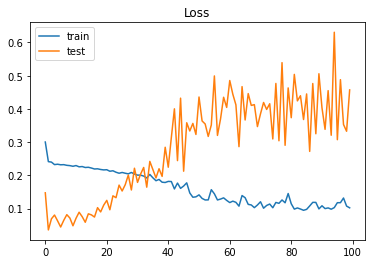

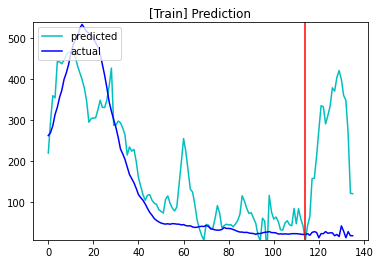

Test MAE: 21.572
============ CITY: IBAGUÉ  ============
Swapped tile ratio: 0.293544671474359
Final output: (114, 1) (22, 1)


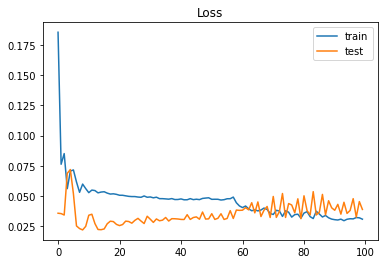

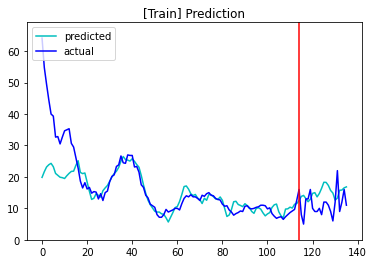

Test MAE: 11.242
============ CITY: VILLAVICENCIO  ============
Swapped tile ratio: 0.2756660657051282
Final output: (114, 1) (22, 1)


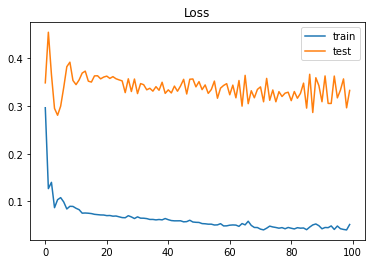

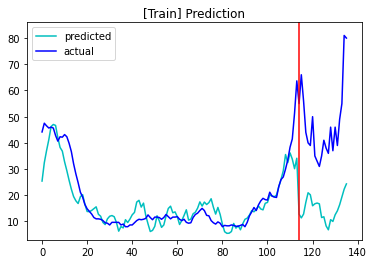

Test MAE: 46.836
============ CITY: CALI  ============
Swapped tile ratio: 0.27291165865384615
Final output: (114, 1) (22, 1)


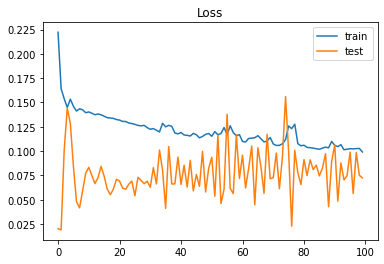

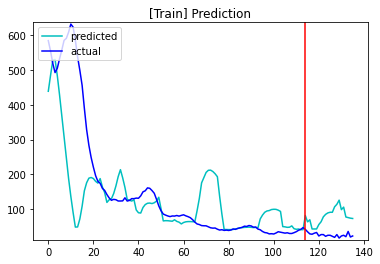

Test MAE: 26.278
============ CITY: CÚCUTA  ============
Swapped tile ratio: 0.2522786458333333
Final output: (114, 1) (22, 1)


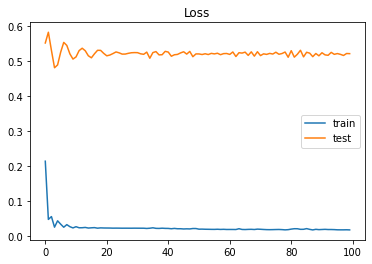

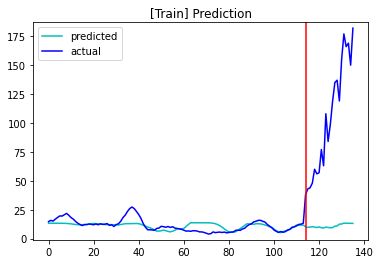

Test MAE: 103.870


In [26]:
filename = dataset_main_folder + '/csv/5_cities_with_img_path/'
for city_csv in os.listdir(filename):
  city = city_csv.split('.')[0]
  data_dic = all_city_data[city]
  case_ls = data_dic['cases']

  if perform_smooth:
    case_ls = smooth_cases(smoothing_length, case_ls, 0.8)

  print('============ CITY:', city.upper(), ' ============')
  # print('Time range:', min(data_dic['epiweek']), '-', max(data_dic['epiweek']))

  train_num = int(len(case_ls) * train_val_ratio)
  avg_img = get_avg_img(data_dic['image'][:train_num])

  tile_height, tile_width = get_pixels_per_tile(avg_img, height_split, width_split)

  # Split the average image into multiple tiles
  avg_img_tiles = split_img_to_tiles(1, avg_img, selected_band, tile_height, tile_width)
  # print('[avg_img_tiles] Average pixel value:', np.average(avg_img_tiles))

  all_img_tiles = run_tile_transformation_on_all(data_dic['image'], selected_band, tile_height, tile_width)
  # print('[All samples] Average pixel value:', np.average(all_img_tiles))

  selected_win_ls = []
  swapped_ratio_list = []
  threshold_ls = []

  # Calculate the standard deviation for each tile
  tile_std = np.std(all_img_tiles, axis=0)

  # Calculate threshold for swapping for each tile
  tiles_in_band = height_split * width_split
  ratio_ls = np.ones((tiles_in_band, 1))
  threshold_ls = calculate_threshold(ratio_ls, tile_std)

  for tiles, img, epiweek in zip(all_img_tiles, data_dic['image'], data_dic['epiweek']):
    updated_img_tiles, ratio = check_every_tile_with_std(tiles_in_band, img, city, 
                                                         tile_height, tile_width, 
                                                         threshold_ls, tiles, avg_img_tiles)  
    
    group_avg = calculate_group_value(updated_img_tiles, height_split, width_split, height_group, width_group)
    selected_win_ls.append(group_avg)
    swapped_ratio_list.append(ratio)

  print('Swapped tile ratio:', np.average(swapped_ratio_list))

  # Prepare input and output for LSTM
  selected_win_ls = np.array(selected_win_ls)
  reshaped_case_ls = case_ls.reshape(-1, 1)
  X_train, X_test, y_train, y_test, scaler = prepare_XY_for_LSTM(selected_win_ls, reshaped_case_ls)

  # frame as supervised learning
  train = series_to_supervised(X_train, n_in=lstm_weeks)
  test = series_to_supervised(X_test, n_in=lstm_weeks)

  n_features = X_train.shape[1]
  train_np, test_np = train.to_numpy(), test.to_numpy()

  clean_train = removeLastWeek(train_np, n_features)
  clean_test = removeLastWeek(test_np, n_features)

  final_X_train = clean_train.reshape((-1, lstm_weeks, n_features))
  final_X_test = clean_test.reshape((-1, lstm_weeks, n_features))
  # print('Final input:', final_X_train.shape, final_X_test.shape)

  # print('------------------------------------------')
  final_y_train = y_train[lstm_weeks:]
  final_y_test = y_test[lstm_weeks:]
  print('Final output:', final_y_train.shape, final_y_test.shape)

  eval_model(final_X_train, final_X_test, final_y_train, final_y_test, scaler)

## Get average band images for different cities

In [ ]:
# Get average band images for different cities
for city_csv in os.listdir(filename):
  city = city_csv.split('.')[0]
  data_dic = all_city_data[city]

  print('============ CITY:', city, ' ============')

  train_num = int(len(data_dic['cases']) * train_val_ratio)
  avg_img = get_avg_img(data_dic['image'])
  tile_height, tile_width = get_pixels_per_tile(avg_img, height_split, width_split)

  for band in range(avg_img.shape[2]):
    selected_img = get_wanted_image_band(band, avg_img)

    tiles_in_band = height_split * width_split
    tile_height, tile_width = get_pixels_per_tile(avg_img, height_split, width_split)

    img_saved_name = city + '_band_' + str(band)
    avg_img_tiles = split_img_to_tiles(1, avg_img, band, tile_height, tile_width)
    select_mask_region(tiles_in_band, city, tile_height, tile_width, selected_img, 
                       img_saved_name, range(len(avg_img_tiles)), [], 
                       avg_img_tiles, avg_img_tiles, avg_img_tiles)

In [ ]:
# Reference LSTM code: https://github.com/MITCriticalData-Colombia/Dengue-MetaData/blob/fusion_time_series/multi_var_time_series/LSTM_multivariate_v2_weekly_temperature.ipynb